In [ ]:
!pip install scvi-tools

In [ ]:
!pip install scanpy

In [ ]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

In [ ]:
save_dir = tempfile.TemporaryDirectory()


In [ ]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmpjxpx8j_b/hca_subsampled_20k.h5ad                                              


Downloading...:   0%|          | 0/65714.0 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [ ]:
sc.pp.filter_genes(adata, min_counts=3)

In [ ]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [ ]:
!pip install --user scikit-misc

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
  continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model.train(max_epochs=40)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/40 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True)

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

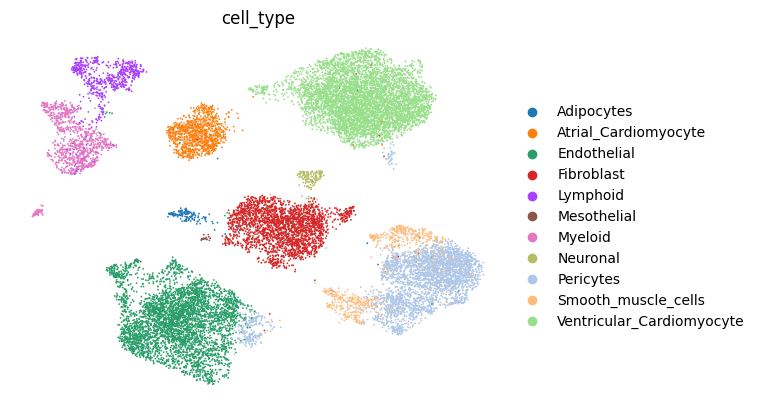

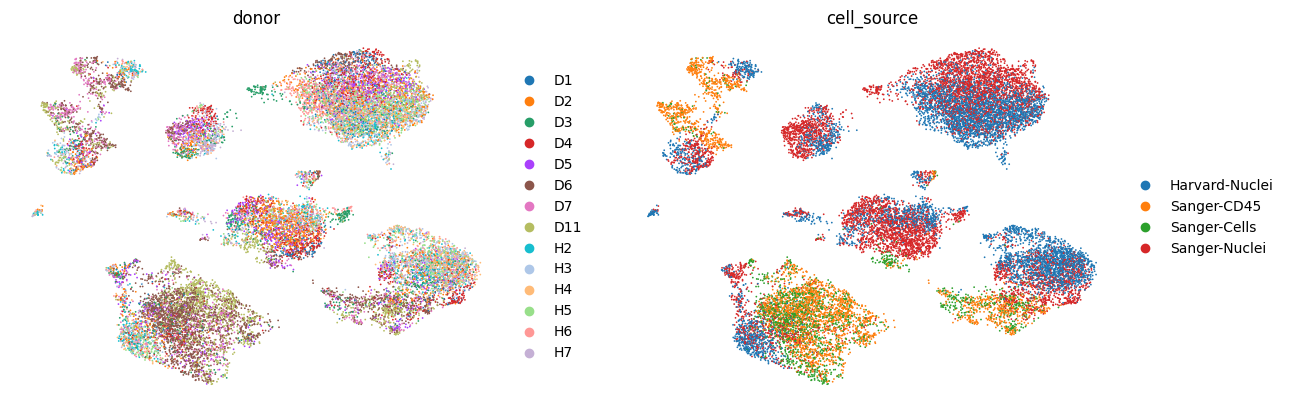

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming you're using PCA or UMAP as the embedding for silhouette score calculation
# Use adata.obsm['X_pca'] or adata.obsm['X_umap'] for the feature space
X = adata.obsm['X_pca']  # or 'X_umap', choose an appropriate embedding

# Get the clusters from adata.obs
labels = adata.obs['clusters']

# Calculate silhouette score
sil_score = silhouette_score(X, labels)
print(f'Silhouette score: {sil_score}')

In [ ]:
ot as plt
from sklearn.metrics import silhouette_score

# Store silhouette scores for different resolutions
resolutions = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
silhouette_scores = []

# Loop over different Leiden resolutions
for res in resolutions:
    # Perform Leiden clustering at the given resolution
    sc.tl.leiden(adata, resolution=res)

    # Calculate silhouette score using the PCA embedding
    sil_score = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'])

    # Append the result to the list
    silhouette_scores.append(sil_score)
    print(f"Resolution {res}: Silhouette score = {sil_score}")

# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'resolution': resolutions,
    'silhouette_score': silhouette_scores
})

# Step 3: Plot the silhouette scores as a barplot
plt.figure(figsize=(8, 5))
plt.bar(results_df['resolution'], results_df['silhouette_score'], width=0.05)
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Leiden Resolutions')
plt.show()